In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sys
import matplotlib as mpl
from scipy.interpolate import griddata 
import warnings
import os
import numpy as np
sys.path.append('C:/Users/shjo/Bridge/JNUpack/mySO_src/libs/')
warnings.filterwarnings('ignore')
from myTools import myInfo
from myTrend import myfitting2d_sttcs,myRegress3d_sttcs, myXRegress
from myPlot import  figmaster,myClrbr, dta_colr
import matplotlib as mpl
# mpl.use('agg')
### ======================================================================
AVISO_pth='D:/AVISO/madt_h/'

myindx='SAM'
varnm='adt'

t_rng=['1993-01', '2017-12']
lat_rng=[-75,-30]; lon_rng=[0,360]

# wpth='C:/Users/shjo/OneDrive/mySO/Regression_H/AVISO_'+myindx+'/'
mySig_npth='C:/Users/shjo/OneDrive/mySO/mySignals/my'+myindx+'.pkl'


### load Index ==================================================================
with open(mySig_npth, 'rb') as f:
    data = pickle.load(f)
myIdx=data.loc['1993-01':'2017-12']
myIdx=myIdx.rolling(window=12,center=True).mean()[6:-5].values.reshape(-1)
# print(mySAM)

### Preparation ============================================================
# wpth=wpth+varnm+str(t_rng[0][:4])+'_'+str(t_rng[-1][:4])+'_'+\
#     str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+'_'+\
#         str(lon_rng[0])+'E'+str(lon_rng[-1])+'E/'
# wpth=wpth.replace('-','')
# try :
#     os.mkdir(wpth)
# except:
#     pass
# loc=sys._getframe().f_code.co_filename
# myInfo(loc,wpth)

### Read Data ==============================================================

# print('!!! Open: '+i+' !!!')
mydata = xr.open_mfdataset(AVISO_pth+'*.nc')[varnm].loc[dict(latitude=slice(lat_rng[0],lat_rng[-1])\
    ,time=slice(t_rng[0],t_rng[-1]),longitude=slice(lon_rng[0],lon_rng[-1]))]

mydata=mydata.where(mydata<1000)
mydata=mydata.where(mydata>-1000)

mydata=mydata.fillna(0)
mydata=mydata-mydata.mean(dim='time')
mydata=mydata.rolling(time=12,center=True).mean()[6:-5]

lonR,latR=mydata.longitude.values,mydata.latitude.values
lonR_m,latR_m=np.meshgrid(lonR,latR)
time=mydata.time.values
dta_nm='SLA '+varnm+' regression ('+myindx+')\n'+\
    str(lon_rng[0])+'~'+str(lon_rng[-1])+'E '+str(time[0])[:4]+' '+str(time[-1])[:4]
dta_snm='SLA '+varnm+' regression '+myindx+'_'+\
    str(lat_rng[0])+'S'+str(lat_rng[-1])+'S'+' '+str(lon_rng[0])+'E'+str(lon_rng[-1])+'E_'+\
        str(time[0])[:4]+' '+str(time[-1])[:4]

dta_snm=dta_snm.replace(' ','_').replace('salt','salinity').replace('-','')
dta_nm=dta_nm.replace('salt','salinity').replace('-','')

### SST Coef =============================================================
print('!!! linregress !!!')
# plt.figure()
# plt.scatter(range(300),mydata[:,30,20])
# plt.show()
# raise

!!! linregress !!!


In [2]:
def myXRegress(Xdata,myIdx):
    '''
    --> 3D xarray.dataarray (myDATA series)
    --> time --> Name of time (str)
    '''
    NC=Xdata.assign_coords({'myIdx':('time',myIdx)})
    NC=NC.swap_dims({'time':"myIdx"})
    NC_s=NC.polyfit(dim='myIdx',deg=1,skipna=False)
    fit = xr.polyval(NC.myIdx, NC_s.polyfit_coefficients)
    Coef=NC_s.polyfit_coefficients[0]
    return Coef


In [11]:
Xdata=mydata
signal=myIdx
# NC=Xdata.assign_coords({'signals':('time',myIdx)})
NC=Xdata.assign_coords({'TT':('time',range(len(Xdata['time'])))})
NC=NC.swap_dims({'time':"signals"})
NC_s=NC.polyfit(dim='signals',deg=1,skipna=False)
fit = xr.polyval(NC.signals, NC_s.polyfit_coefficients)
Coef=NC_s.polyfit_coefficients[0].values



In [31]:
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf

def myCrtpy_sph3_box(LAT,LON,DATA,CMAP,LEVELS,tnm,myName,lat_rng,lon_rng):
    
    a,b=[lon_rng[0], lon_rng[0]],[lat_rng[0],lat_rng[-1]]
    c,d=[lon_rng[-1], lon_rng[-1]],[lat_rng[0],lat_rng[-1]]
    e,f=[lon_rng[0], lon_rng[-1]],[lat_rng[0],lat_rng[0]]
    g,h=[lon_rng[0], lon_rng[-1]],[lat_rng[-1],lat_rng[-1]]
    
    Spheric=ccrs.SouthPolarStereo(central_longitude=0.0,globe=None)
    PC = ccrs.PlateCarree(central_longitude=0.0,globe=None)
    fig, ax = plt.subplots(1, 1, figsize=(12.5,11),
                    subplot_kw={'projection': Spheric})
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.add_feature(cf.COASTLINE.with_scale("110m"), lw=1,zorder=110)
    ax.add_feature(cartopy.feature.LAND,color=[.75,.75,.75],zorder=100)
    ax.set_title(tnm,loc='right',fontdict={'fontsize':32,'fontweight':'regular'})

    gl = ax.gridlines(crs=PC, draw_labels=True,y_inline=False,x_inline=False,
                    linewidth=.6, color='k', alpha=0.45, linestyle='-.')
    gl.rotate_labels=False
    gl.xlabels_top,gl.ylabels_right = True,True
    gl.xlabel_style = gl.ylabel_style = {"size" : 26}
    
    ax.plot(a,b,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    ax.plot(c,d,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    ax.plot(e,f,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    ax.plot(g,h,transform=PC,color='k',linestyle='--',linewidth=2.5,zorder=200)
    
    # plt.contourf(LON,LAT,HATCH,levels=LEVELS,colors='none',hatches='.',transform=PC,zorder=2,extend='both')
    # M=plt.contourf(LON,LAT,DATA,cmap=CMAP,levels=LEVELS,transform=PC,zorder=0,extend='both')
    M=plt.pcolormesh(LON,LAT,DATA,cmap=CMAP,transform=PC,zorder=0,vmin=-0.001,vmax=0.001)

    # M=plt.contourf(LON,LAT,DATA,cmap=CMAP,transform=PC,zorder=0,extend='both')

    ax.set_extent([LON[0][0], LON[0][-1], LAT[0][0], LAT[-1][0]], crs=PC)
    
    ax.tick_params(axis='both', which='major', labelsize=28)

    divider = make_axes_locatable(ax)
    ax_cb = divider.new_horizontal(size="5%", pad=1., axes_class=plt.Axes)
    fig.add_axes(ax_cb)
    cb=plt.colorbar(M,extend='both',pad=0.08,cax=ax_cb)
    cb.set_label(label='', weight='regular',fontsize=28)
    cb.ax.tick_params(labelsize=19)
    plt.tight_layout()
    if 0:
        myName.replace(' ','_')
        # plt.savefig(w_path+'/ppt/'+save_name,
        #         facecolor='none',edgecolor='none',bbox_inches='tight',transparent=True)
        plt.savefig(self.wpth+'/'+myName.replace(' ','_'))
    plt.show()

In [32]:
myN=15
mylim=[-.0001,.0001]
myCMAP,mylevel=myClrbr('balance',mylim,myN)
# CMAP,mylevel=myClrbr('myblc2',mylim,myN)

# mySetting={
#     'figsize': '',
#     'mylabel': '',
#     'Label_size':18,
#     'title_loc':'right',
#     'fontParams':'Arial',
#     'wpth':'wpth'}

# lat_rng_,lon_rng_=[-60,-53],[200,250]

# F=figmaster(mySetting)
# print(dta_snm)
# F.myCrtpy_sph3_box(latR_m,lonR_m,Coef,myCMAP,mylevel,dta_nm,dta_snm,lat_rng_,lon_rng_)

    

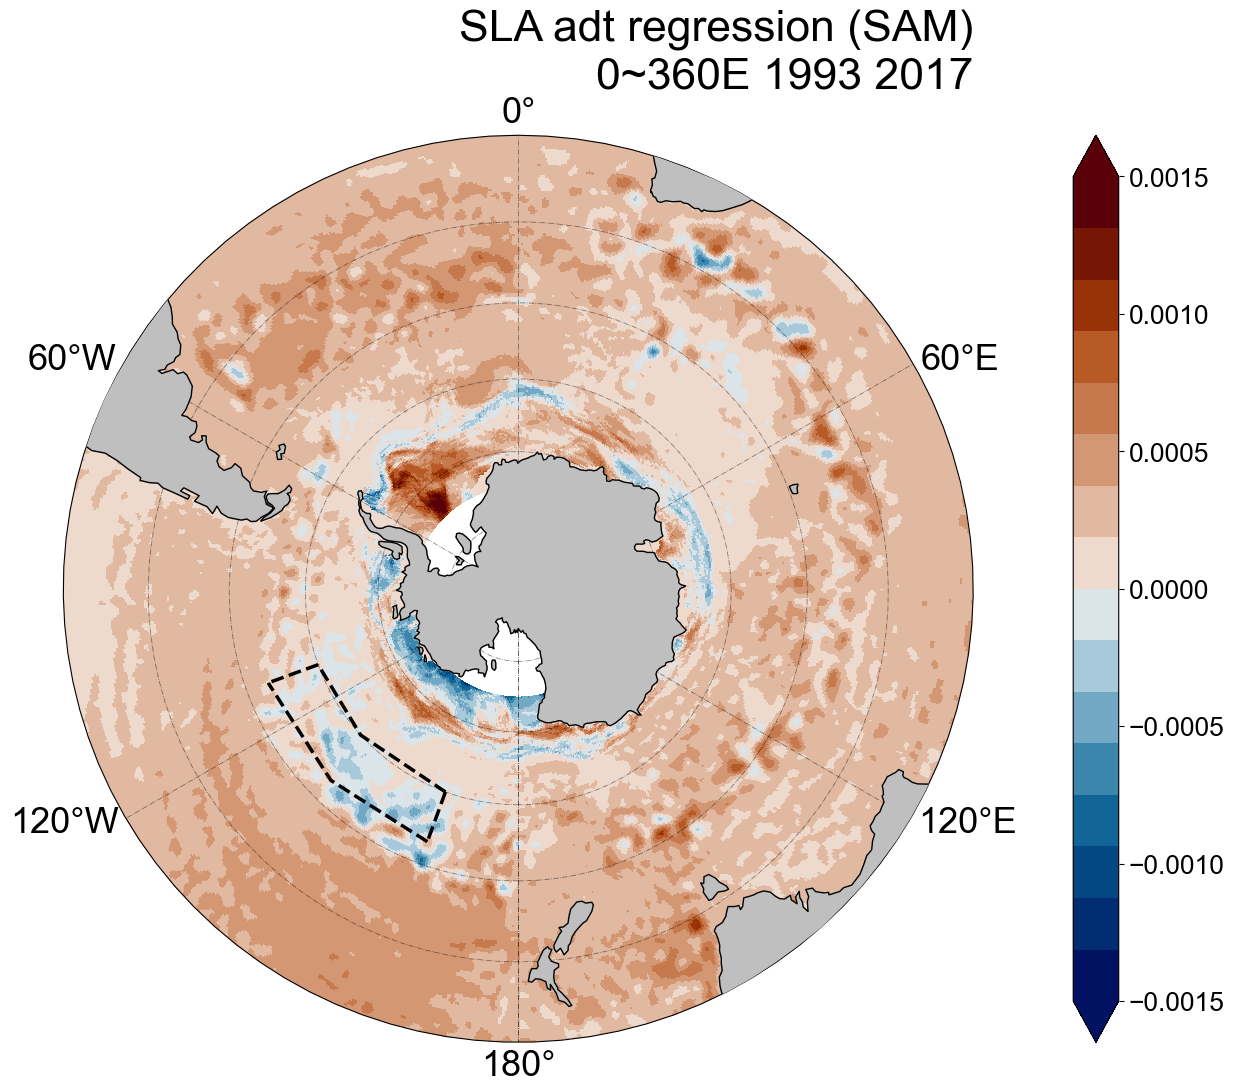

In [33]:
lat_rng_,lon_rng_=[-60,-53],[200,250]
myCrtpy_sph3_box(latR_m,lonR_m,Coef,myCMAP,mylevel,dta_nm,dta_snm,lat_rng_,lon_rng_)

In [27]:
print(np.nanmax(Coef))
print(np.nanmin(Coef))

0.0018246240172877803
-0.0015495350884606738
